First, we will start with some useful imports for the whole experiment

In [2]:
import pip
pip.main(['install','seaborn'])
pip.main(['install','xgboost'])
pip.main(['install','optuna'])

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.


You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


0

In [3]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import patches
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import mean_absolute_error

In [4]:
with open('./data/ass3.pickle', 'rb') as handle:
        data = pickle.load(handle)

In [5]:
X, y = data['train']
df = pd.DataFrame(X)
df['target'] = pd.DataFrame(y)

#for convenience we shall convert X and y to be dataframes.
X = pd.DataFrame(X)
y = pd.DataFrame(y)

Now, we will start the data explortaion. We will start by looking at the shape of the data, so we can know how many samples we have and how many feature we have in each sample

In [6]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48226 entries, 0 to 48225
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       48226 non-null  float64
 1   1       48226 non-null  float64
 2   2       48226 non-null  float64
 3   3       48226 non-null  float64
 4   4       48226 non-null  float64
 5   5       48226 non-null  float64
 6   6       48226 non-null  float64
 7   7       48226 non-null  float64
 8   8       48226 non-null  float64
 9   9       48226 non-null  float64
 10  10      48226 non-null  float64
 11  11      48226 non-null  float64
 12  12      48226 non-null  float64
dtypes: float64(13)
memory usage: 4.8 MB


We can see that we have 13 non-null numerics features, and we have a little bit over 48K samples. We will see some statistics of the data, maybe that will help us get a better understanding of the data. Also, we will look at a histogram of the data.

In [7]:
print(f"Train set shape: {df.shape} \n")
df.describe()

Train set shape: (48226, 14) 



,0,1,2,3,4,5,6,7,8,9,10,11,12,target
count,48226.000000,48226.000000,48226.000000,48226.000000,48226.000000,48226.000000,48226.0,48226.000000,48226.000000,48226.000000,48226.000000,48226.000000,48226.000000,48226.000000
mean,16.004562,0.105586,0.735586,10.817518,187.290860,10.352022,0.0,1003.932030,129.225065,15.720814,6.512068,2011.008066,11.504894,11.908445
std,4.356320,0.325019,0.195201,6.910443,107.551301,4.197180,0.0,113.986487,56.274402,8.801837,3.452912,3.156469,6.936294,9.536024
min,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.000000,1.000000,2006.000000,0.000000,-21.822222
25%,17.000000,0.000000,0.600000,5.832225,114.000000,8.307600,0.0,1011.910000,95.000000,8.000000,4.000000,2008.000000,5.000000,4.588889
50%,18.000000,0.000000,0.780000,9.982000,180.000000,10.046400,0.0,1016.440000,118.000000,16.000000,7.000000,2011.000000,11.000000,11.991667
75%,19.000000,0.000000,0.900000,14.135800,290.000000,14.860300,0.0,1021.100000,181.000000,23.000000,10.000000,2014.000000,18.000000,18.838889
max,26.000000,1.000000,1.000000,55.931400,359.000000,16.100000,0.0,1046.260000,213.000000,31.000000,12.000000,2016.000000,23.000000,39.588889


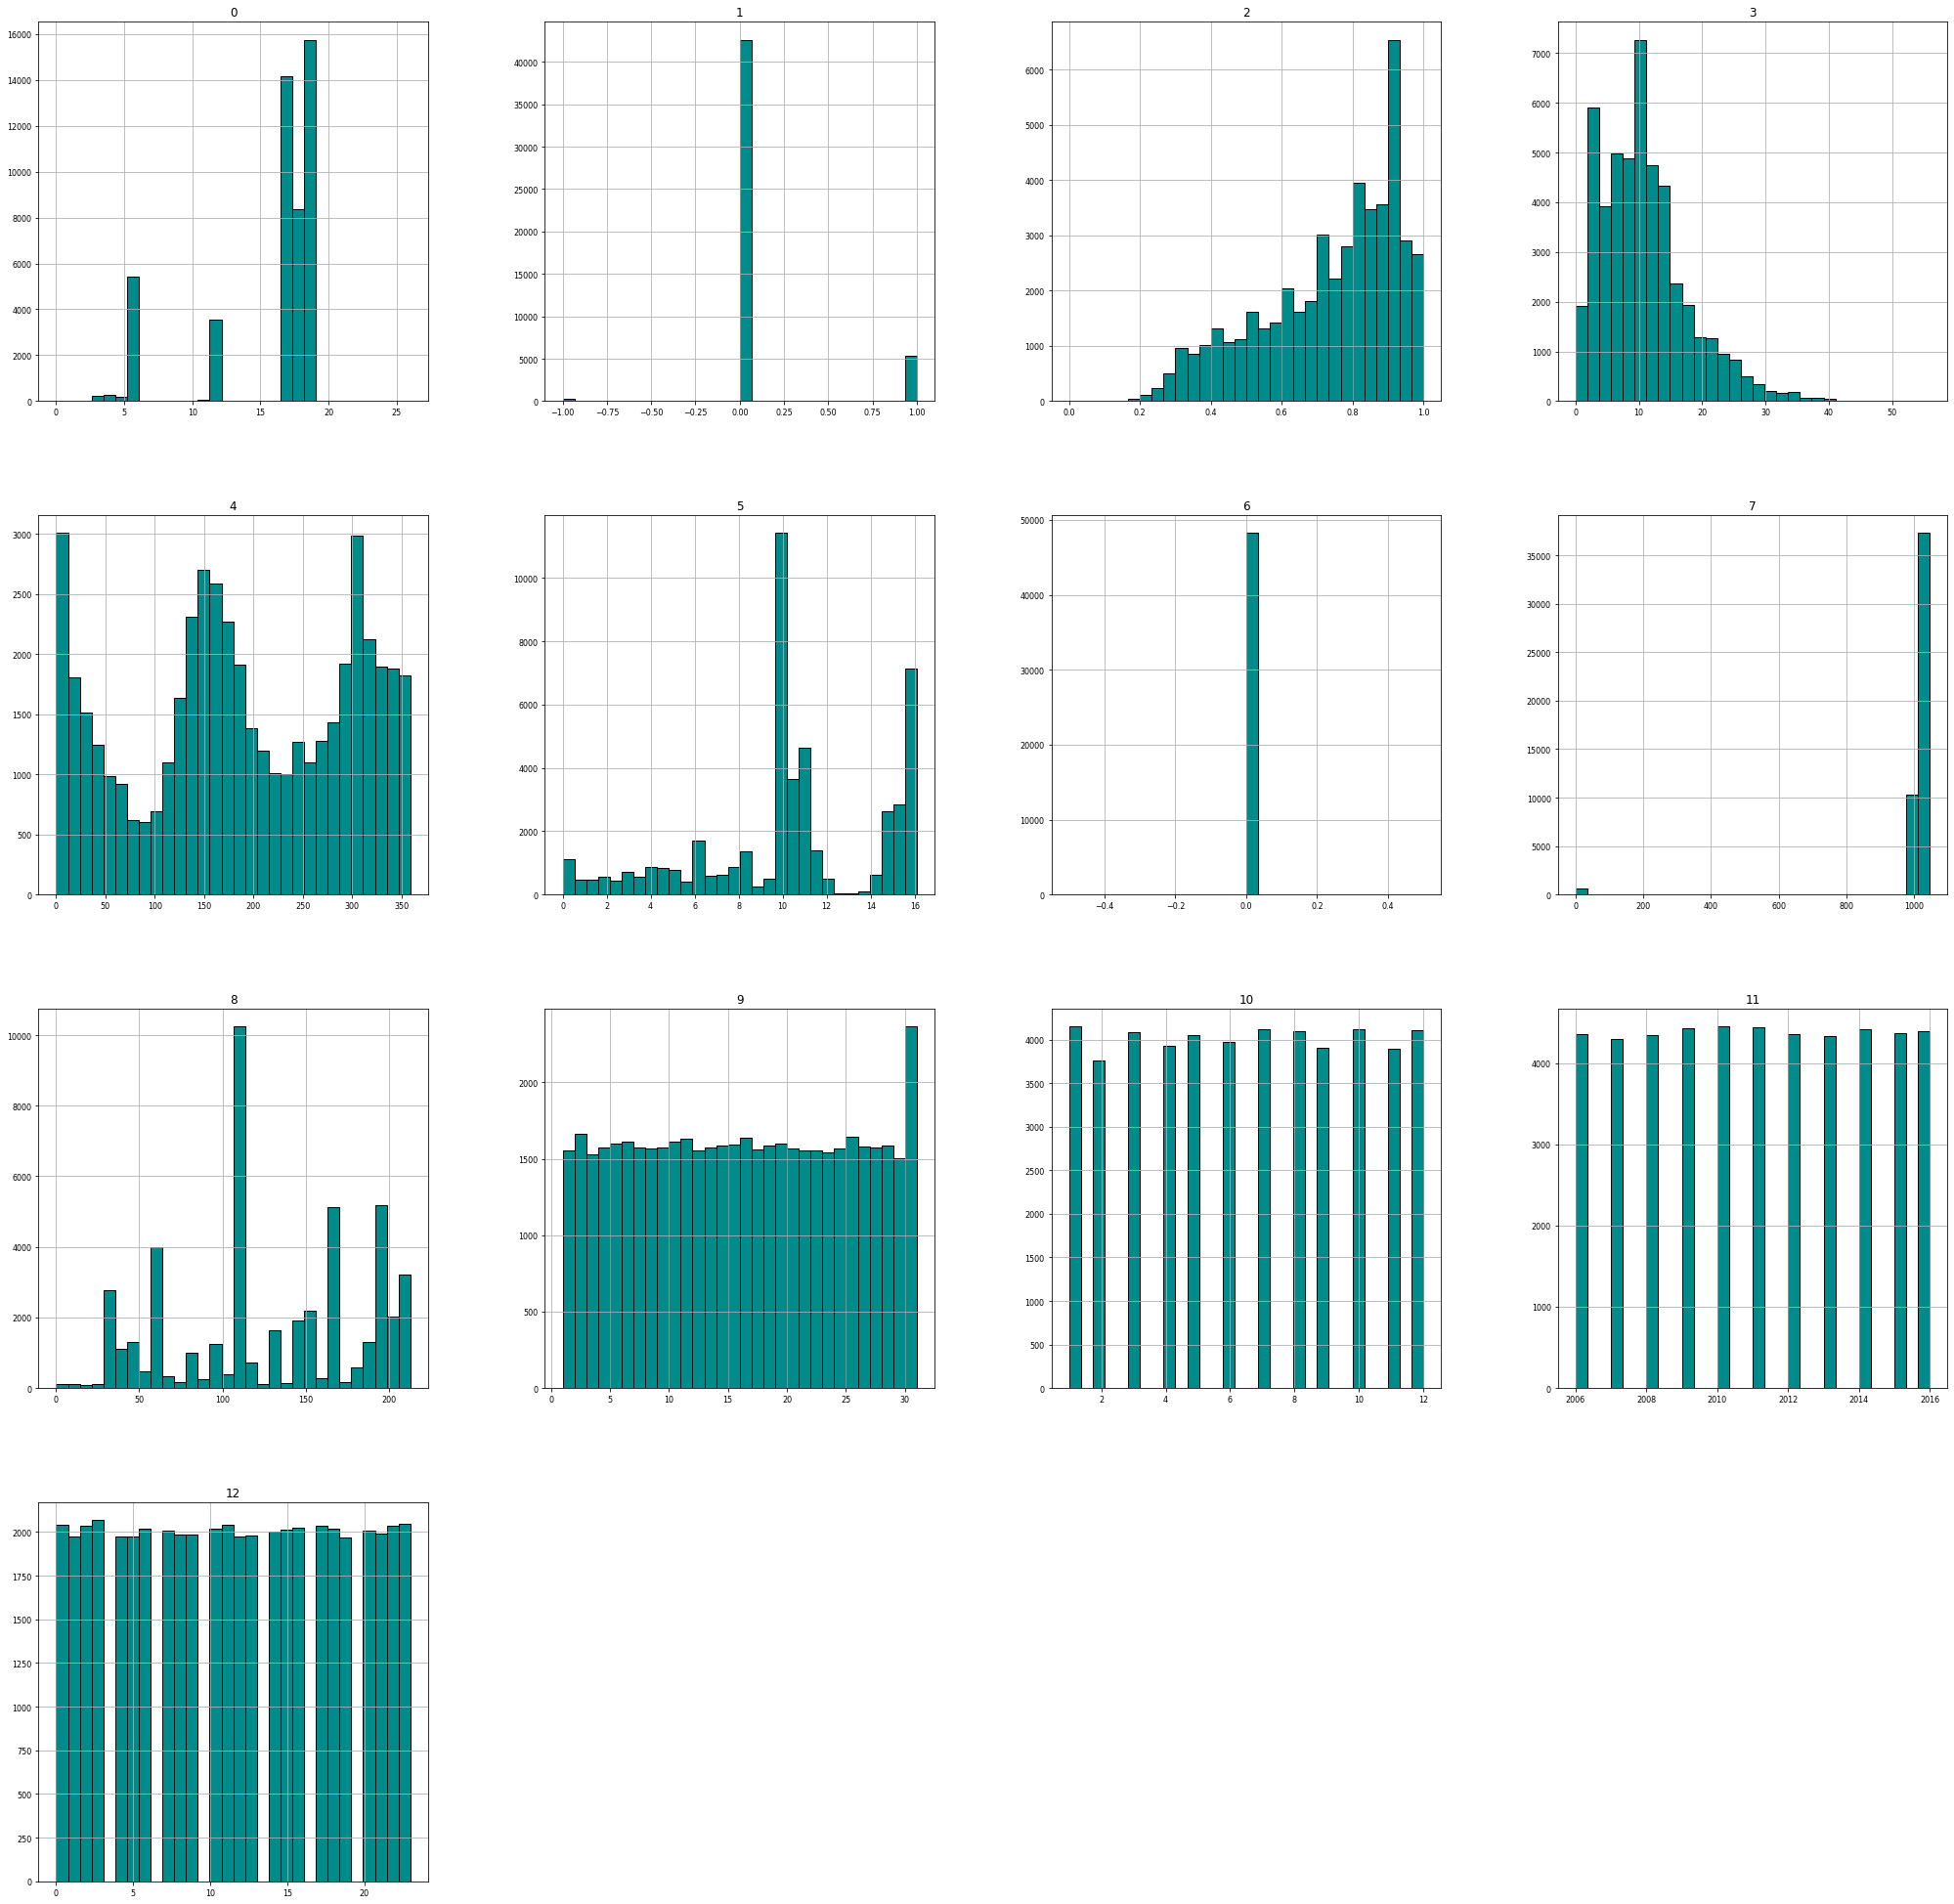

In [8]:
histogram = X.hist(figsize=(35, 35), bins=30, color="darkcyan", edgecolor="black", xlabelsize=8, ylabelsize=8)

We can see that column 6 in a constant zero (the standard deviation is zero).  Therefore it does not give us any information, so we can drop it. 
Also, we can see that columns 9, 10 and 11 are 12 gets values from final sets. 
Feature 9 gets only integers between 1-31, feature 10 gets only integers between 0-12, feature 11 gets only integers from 2006-2012. (Therefore, we can guess that those three columns represent a date). Column 12 gets integer values between 0-23 (we can guess that this column represents a hour of the day).

Moreover, We can see that column 7 is also quite close to being constant. More than 75% of the values are in the range between 1000-1030. 
We will try to check the distribution of this feature, and maybe see if there are outliers in the data.

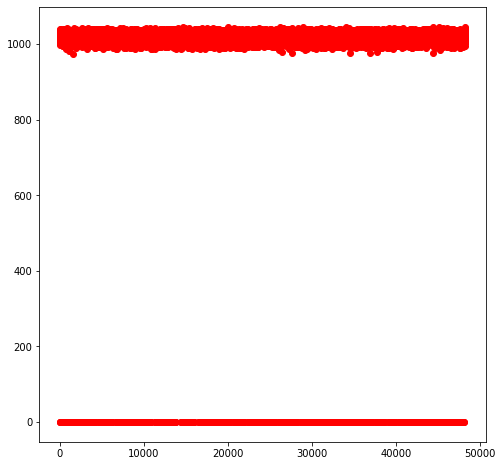

In [9]:
#Check The values of feature 7 and see it in a graph
feature_values = X[7].values.tolist()
n = len(feature_values);
f7_outliers = [i for i in range(n) if feature_values[i] < 800]
#print(f7_outliers)
plt.figure(figsize=(8, 8))
plt.scatter(range(n), feature_values, marker='o', color='red')
plt.show()

We can see that feature 1 has also some data that is quite far from the majority, we'll take a look at it.

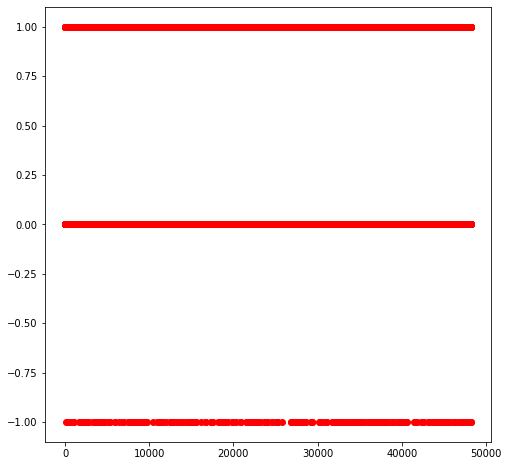

In [10]:
#Check The values of feature 1 and see it in a graph
feature_values = X[1].values.tolist()
n = len(feature_values)
f1_outliers = [i for i in range(n) if feature_values[i] < 0]
#print(f1_outliers)
plt.figure(figsize=(8, 8))
plt.scatter(range(n), feature_values, marker='o', color='red')
plt.show()

We can look and see if there are any samples that are outliers of feature 1 and also of feature 7.

In [11]:
possible_outliers = f7_outliers + f1_outliers
print(list(set(f7_outliers) & set(f1_outliers)))

[]


There are no mutual samples, but we will keep the possible outliers. We will later check if removing them from the train gets better results.

After we understood that columns 9-11 represents a date, we will check if there is any connection between each day, month or year to the target.

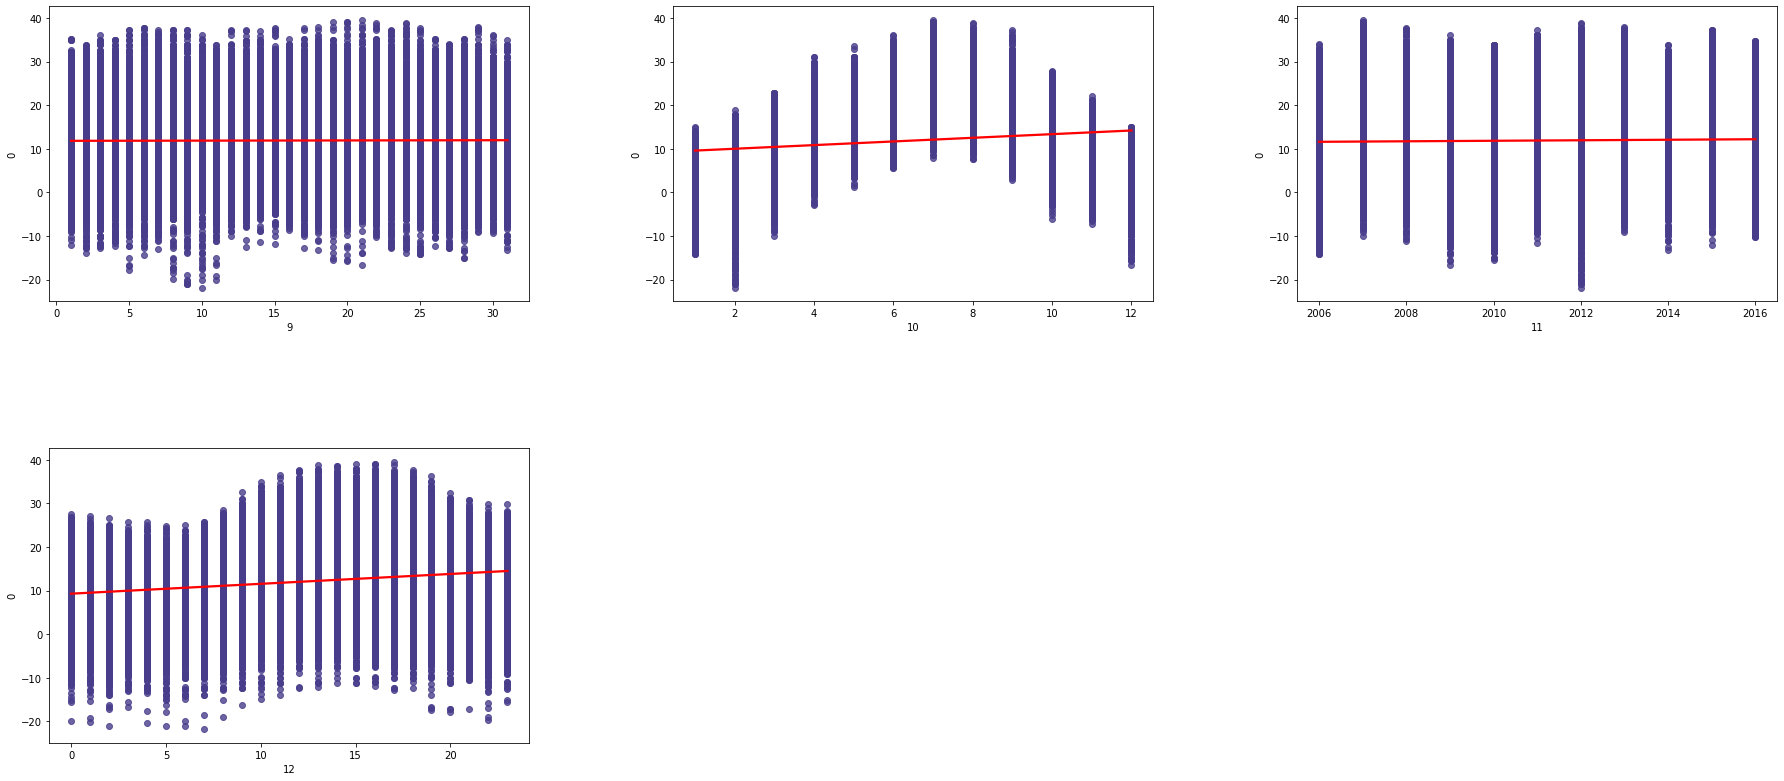

In [12]:
fig = plt.figure(figsize=(30,50))
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=1.9,
                    wspace=0.3,
                    hspace=0.5)
columns = [9, 10, 11, 12]
i = 0
for col in columns:
        plt.subplot(15,3,i+1)
        sns.regplot(x=X[col], y=y, scatter_kws={"color": "darkslateblue"}, line_kws={"color": "red"})
        i = i + 1

We can see that each feature has about the same target values. We can see one things and is that in the plot of feature 10 (which represents the month), the in the middle of the year the target is the highest, and in the beggining and in the end of the year the target is the lowest, which is interesting.

We will look at the correlation matrix, to see whether there are feautres that have a linear correlation between them.

<AxesSubplot:>

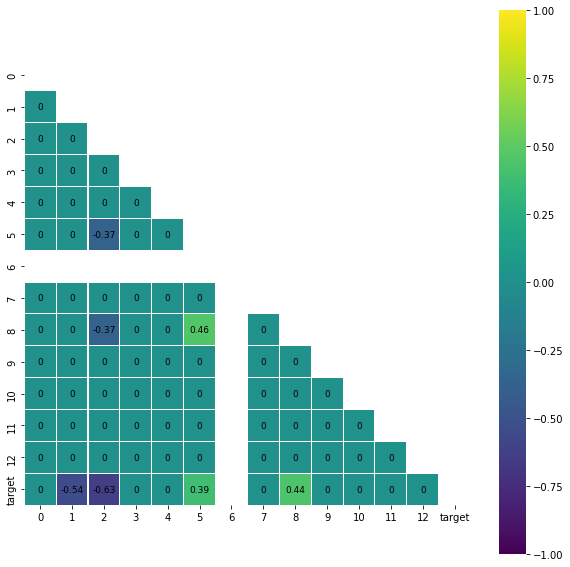

In [13]:
fig = plt.figure(figsize=(10,10))
pd.options.display.float_format = "{:,.2f}".format
corr_matrix = df.corr(method = 'pearson')

#for better readability we replace correlation that is less than 0.3 with 0
corr_matrix[(corr_matrix < 0.3) & (corr_matrix > -0.3)] = 0
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, vmax=1.0, vmin=-1.0, linewidths=0.1,
            annot_kws={"size": 9, "color": "black"}, square=True, cmap="viridis", annot=True)

We don't have any features that are strongly correlated (|correlation| > 0.7), so we won't be removing features based on the correlation.

We shall remove column 6 (which only has one value - 0), and see what is the best model.
We will split the data into train, validation and test. To prevent data leak, we can't decide on the right model based on

In [14]:
X = X.copy().drop(columns = [6])
X
X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.8, random_state = 42)
X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5, random_state = 42)

RandomForest started
1.5014822263690186
AdaBoost started
3.2157907790838736
GradientBoosting started
2.4131209568338035
KNN started
4.566552169004999
LinearRegression started
4.782167758674163
XGBoost started
1.7045440167582397
Dummy started
7.99227829611541


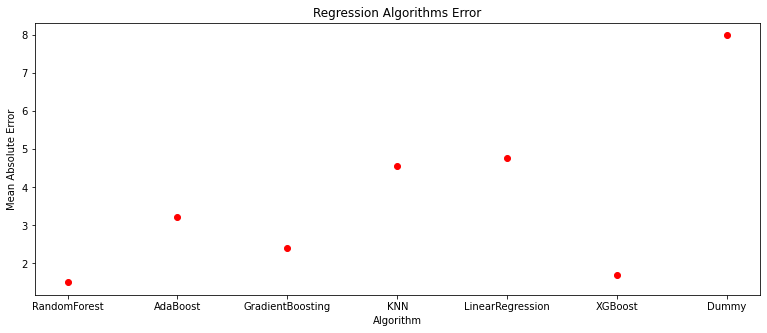

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

models = [
            ('RandomForest', RandomForestRegressor()),
            ('AdaBoost', AdaBoostRegressor()),
            ('GradientBoosting', GradientBoostingRegressor()),
            ('KNN', KNeighborsRegressor()),
            ('LinearRegression', LinearRegression()),
            ('XGBoost', XGBRegressor()),          
            ('Dummy', DummyRegressor())
         ]

names = [name for (name, model) in models]
results = []

for name,model in models:
    print(f"{name} started")
    regressor = model.fit(X_train, y_train.values.ravel())
    y_pred = regressor.predict(X_valid)
    print(mean_absolute_error(y_valid, y_pred))
    results.append(mean_absolute_error(y_valid, y_pred))

#some plotting configurations
x = np.array(range(len(models)))
plt.figure(figsize=(13,5))
plt.title('Regression Algorithms Error')
plt.xlabel('Algorithm')
plt.ylabel('Mean Absolute Error')
plt.scatter(x, results, marker='o', color='red')   
plt.xticks(x, names)
plt.show()


We found that RandomForest and XGBoost are the best models. Not surprising at all. We will make an experiment to test what are the best hyperparemters for those. We will use optuna for this purpose.

In [16]:
import optuna

from optuna.samplers import TPESampler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import make_scorer

def objective(trial):

    regressor_name = trial.suggest_categorical("regressor", ["XGBoost", "RandomForest"])
    if regressor_name == "RandomForest":
        n_estimators = trial.suggest_int("rf_n_estimators", 10, 100, log=True)
        max_depth = trial.suggest_int("rf_max_depth", 2, 10, log=True)
        min_samples_leaf = trial.suggest_int("rf_min_samples_leaf", 2, 10)
        regressor_obj = RandomForestRegressor(
            max_depth=max_depth, n_estimators=n_estimators, min_samples_leaf=min_samples_leaf)
    if regressor_name == 'XGBoost':
        n_estimators = trial.suggest_int("xgb_n_estimators", 10, 100, log=True)
        max_depth = trial.suggest_int("xgb_max_depth", 0, 10)

        learning_rate = trial.suggest_float("xgb_learning_rate", 0.01, 0.5, log=True)
        regressor_obj = XGBRegressor(max_depth=max_depth, n_estimators=n_estimators, learning_rate=learning_rate)
    else:
        exit('error: unknown regressor')
        
    score = cross_val_score(regressor_obj, X_train, y_train, n_jobs=-1, cv=5, scoring=make_scorer(mean_absolute_error))
    mean_abs = score.mean()
    return mean_abs

study = optuna.create_study(direction="minimize", sampler=TPESampler())
study.optimize(objective, n_trials=150)
print('best_trial\n', study.best_trial)
print('best_params\n', study.best_params)
print('best_value\n', study.best_value)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2022-07-03 17:52:25,877] A new study created in memory with name: no-name-89f09f1c-1f61-4290-9559-b241388d023f
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
5 fits failed out of a total of 5.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versio

best_trial
 FrozenTrial(number=126, values=[1.3726164730123456], datetime_start=datetime.datetime(2022, 7, 3, 18, 1, 21, 166610), datetime_complete=datetime.datetime(2022, 7, 3, 18, 1, 29, 190945), params={'regressor': 'XGBoost', 'xgb_n_estimators': 100, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.18733859386250637}, distributions={'regressor': CategoricalDistribution(choices=('XGBoost', 'RandomForest')), 'xgb_n_estimators': IntLogUniformDistribution(high=100, low=10, step=1), 'xgb_max_depth': IntUniformDistribution(high=10, low=0, step=1), 'xgb_learning_rate': LogUniformDistribution(high=0.5, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=126, state=TrialState.COMPLETE, value=None)
best_params
 {'regressor': 'XGBoost', 'xgb_n_estimators': 100, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.18733859386250637}
best_value
 1.3726164730123456


Optuna output:

<p>
...
[I 2022-07-03 18:27:34,036] Trial 146 finished with value: 2.376865268784166 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 95, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.022303519316431326}. Best is trial 126 with value: 1.3726164730123456.
[I 2022-07-03 18:27:37,028] Trial 147 finished with value: 1.6504053614406307 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 32, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.14538955200216885}. Best is trial 126 with value: 1.3726164730123456.
[I 2022-07-03 18:27:42,998] Trial 148 finished with value: 1.4871351762637306 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 82, 'xgb_max_depth': 9, 'xgb_learning_rate': 0.1594546055047679}. Best is trial 126 with value: 1.3726164730123456.
[I 2022-07-03 18:27:50,921] Trial 149 finished with value: 1.3850463735426053 and parameters: {'regressor': 'XGBoost', 'xgb_n_estimators': 91, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.20359902262554322}. Best is trial 126 with value: 1.3726164730123456.
best_trial
 FrozenTrial(number=126, values=[1.3726164730123456], datetime_start=datetime.datetime(2022, 7, 3, 18, 1, 21, 166610), datetime_complete=datetime.datetime(2022, 7, 3, 18, 1, 29, 190945), params={'regressor': 'XGBoost', 'xgb_n_estimators': 100, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.18733859386250637}, distributions={'regressor': CategoricalDistribution(choices=('XGBoost', 'RandomForest')), 'xgb_n_estimators': IntLogUniformDistribution(high=100, low=10, step=1), 'xgb_max_depth': IntUniformDistribution(high=10, low=0, step=1), 'xgb_learning_rate': LogUniformDistribution(high=0.5, low=0.01)}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=126, state=TrialState.COMPLETE, value=None)
best_params
 {'regressor': 'XGBoost', 'xgb_n_estimators': 100, 'xgb_max_depth': 10, 'xgb_learning_rate': 0.18733859386250637}
best_value
 1.3726164730123456
</p>

# Running best parameters on our data
Resulted in an improvment, down to 1.373 which is the best result so far. 

In [18]:
model = XGBRegressor(
            max_depth=10, n_estimators=100, learning_rate=0.18733)
regressor_obj = model.fit(X_train, y_train.values.ravel())
y_pred = regressor_obj.predict(X_valid)
error = mean_absolute_error(y_valid, y_pred)
print(error)

1.3183635527136786


max_depth - The maximum depth of a tree <br/>
n_estimators - represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data<br/>
learning_rate - eta